# Equitable Sales Region Division in Riyadh Using Geospatial Analysis

In [1]:
import sys
import os
import json
parent_dir = os.path.abspath(os.path.join(os.path.dirname("../__init__.py"), ".."))
sys.path.insert(0, parent_dir)

import pandas as pd
from sales_man_problem import *

## Introduction

In this analysis, we address a common problem in sales territory management: how to divide a city into equitable regions so that each salesman gets an equal market share. The challenge arises when considering both the population distribution and destination locations, as neither factor alone ensures fairness.

Jeddah, our region of interest, has the following statistics:

- **Total Population:** 7 Million but we have data only for 5 Million
- **Male Percentage:** 62.6%
- **Female Percentage:** 34.7%
- **Total destinations in dataset:** 11851 places that belong to 67 distint types

Our goal is to divide Jeddah into sales regions that balance both consumer demand and destination access.

In [ ]:
bounding_box = [(46.831005, 24.875028),
                (46.918779, 24.595223),
                (46.617594, 24.513821),
                (46.507446, 24.803183)]

population_data = gpd.GeoDataFrame.from_features(pd.read_json("../../population.json").features)
points = population_data.geometry.map(lambda x: x.centroid)
population_data["longitude"] = points.map(lambda x: x.x)
population_data["latitude"] = points.map(lambda x: x.y)
population_data = pd.DataFrame(population_data.drop("geometry", axis=1)).rename(columns={"PCNT":"population", "GLEVEL":"zoom_level"})

places_data = pd.read_csv("../../places_data.csv").rename(columns={"response_data":"data"})
places_data.data = places_data.data.map(json.loads)
places = get_places_data(places_data=places_data, 
                            bounding_box=bounding_box).assign(longitude=lambda x: x.geometry.x,
                                                                latitude=lambda x: x.geometry.y)

population = get_population_by_zoom_in_bounding_box(population_data=population_data, 
                                                        zoom_level=16, 
                                                        bounding_box=bounding_box)

### Types of destination and their frequecies in the given data

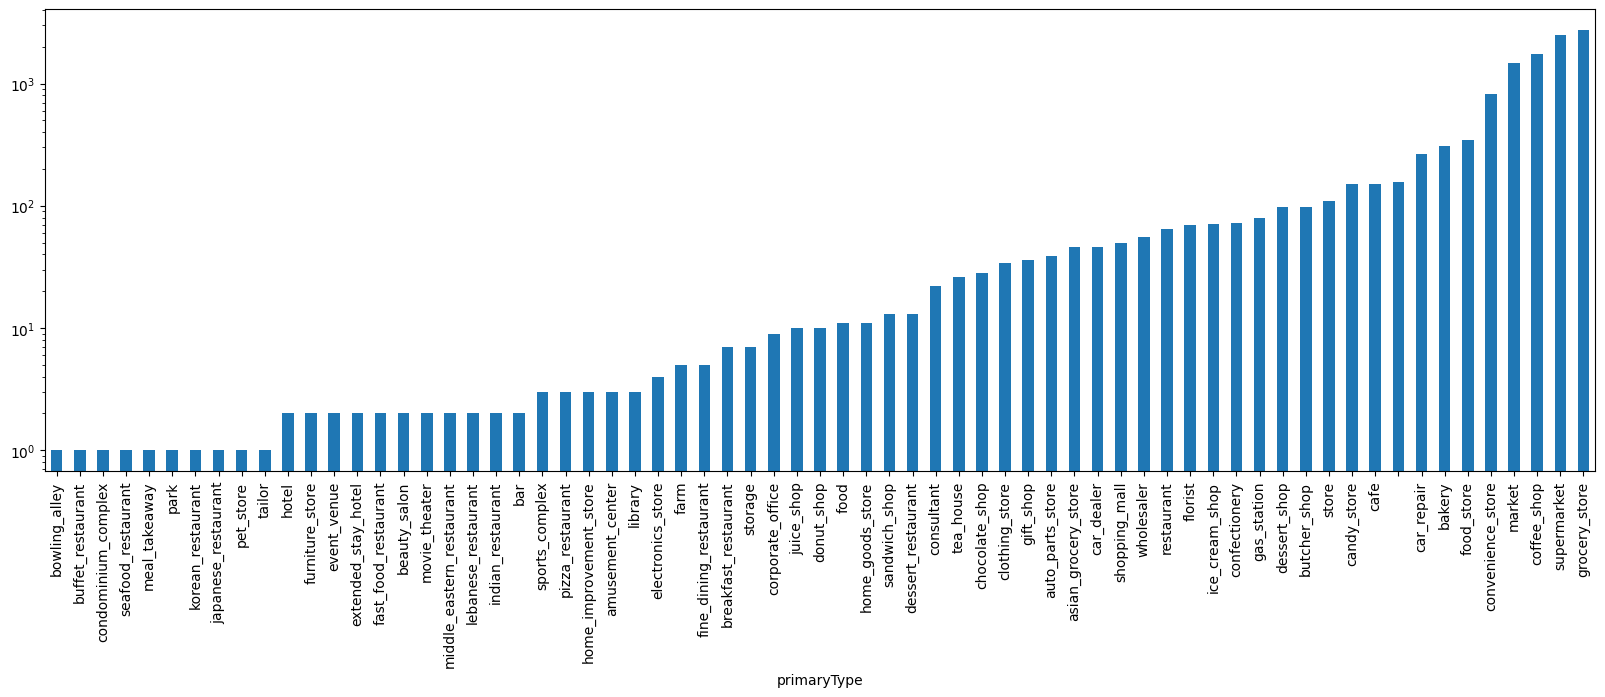

In [23]:
plt.figure(figsize=(20,6))
places.groupby("primaryType", observed=False)["index"].count().sort_values().plot.bar()
plt.yscale("log")

## Problem Statement

A company has multiple salesmen, each assigned a specific region within the city. If we divide the city based on population alone without considering destinations' locations, some sales regions may be underserved. Conversely, dividing solely based on destinations ignores consumer demand.

To achieve an equitable division, we introduce a metric that accounts for both factors: **effective population per destination**. This ensures that each salesman gets a region with a fair market share.


## Methodology

### Step 1: Calculate destination Accessibility

The first step is to determine how many destinations are accessible from each population center. We define accessibility based on three distance thresholds:

- **1 km**: Represents walkable access.
- **5 km**: Represents short driving access.
- **10 km**: Represents extended reach.

This requires calculating an **origin-destination distance matrix**, where each origin is a population center and each destination is a destination.

### Step 2: Compute Market Share

Once the distance matrix is computed, we invert it to determine how many population centers can access each destination. Using this data, we calculate the market share of each destination as follows:

#### Mathematical Formulation

For a given population center *i*:

$$
ef_i = \frac{P_i * W_i}{S_i}
$$

**Where:**

- $ef_i$ = Effective population for population center *i*
- $P_i$ = Population of center *i*
- $S_i$ = Number of destinations accessible from center *i*
- $W_i$ = Weighage of each population center forexample average income etc.

For a given destination *j*:

$$
ms_j = \sum ef_{ij} \quad \text{for all centers that can access destination } j
$$

**Where:**

- $ms_j$ = Market share of destination *j*
- $ef_{ij}$ = Effective population from all population centers *i* accessing destination *j*

### Assumptions

To simplify the analysis, we make the following assumptions:

1. Consumer demand is evenly distributed across the region. This assumption is considered when $W_i$ is not provided to calculate the $ef_i$
2. All destinations provide the same range of products.
3. Salesmen cover their designated areas without overlap.

### Step 3: Clustering for Equitable Sales Regions

Once the market share is computed, we use **clustering algorithms**  to divide Jeddah into sales regions. The key difference in our approach is that **market share**, not population density or geographical area, is the basis for clustering.

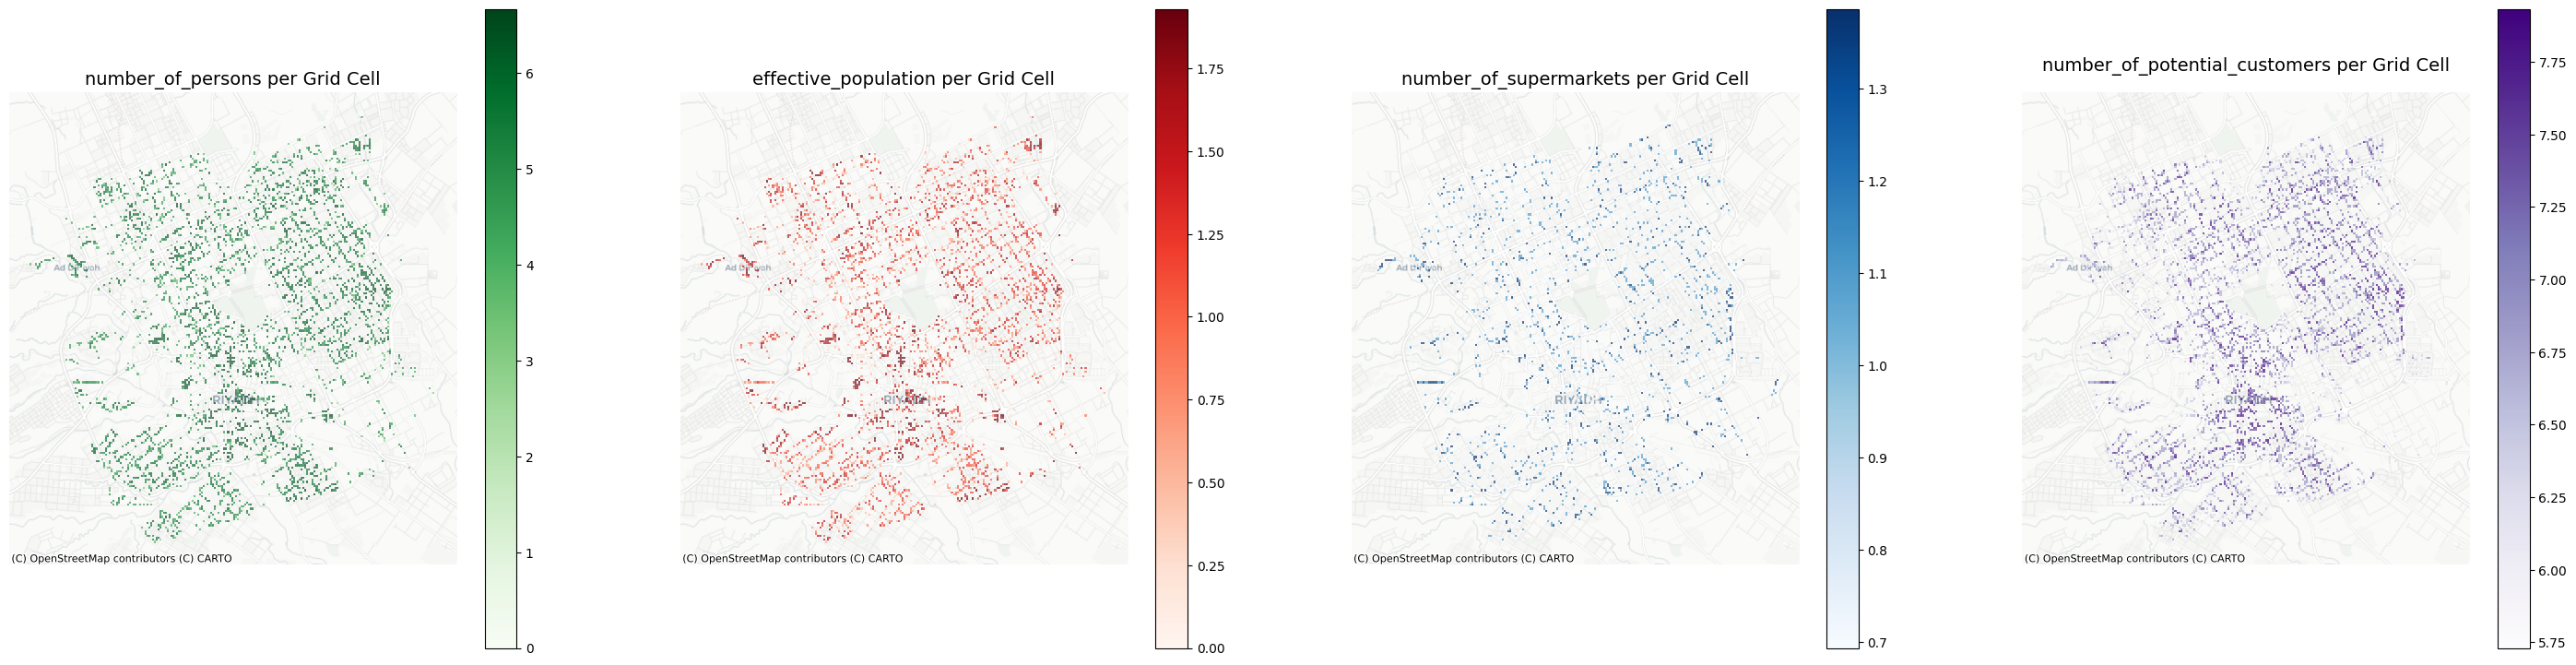

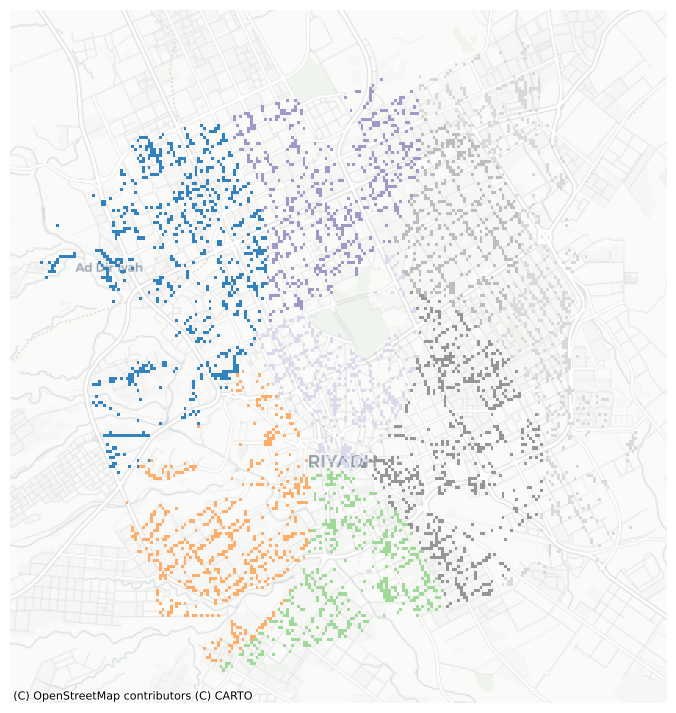

In [3]:
# import pickle as pkl
# with open("../../results.pkl", "rb") as file:
#     data = pkl.load(file)

data = get_clusters_for_sales_man(num_sales_man=8, 
                                  population=population_data, 
                                  places=places_data,
                                  weights=None,
                                  bounding_box=bounding_box, 
                                  distance_limit=2.5,
                                  zoom_level=16)

plot_results(data.iloc[:,:-1], 4, 1, ["Greens", "Reds", "Blues", "Purples"], alpha=0.75)
plot_results(data[["geometry", "group"]], 1, 1, ["tab20c"], alpha=1, show_legends=False, edge_color=None, show_title=False)

,number_of_persons,effective_population,number_of_supermarkets,number_of_potential_customers
group,,,,
0,135603.0,1218.668273,1087.0,658435.226913
1,152031.0,1324.640340,820.0,658795.364857
2,134052.0,871.536637,702.0,658312.959105
3,138996.0,1028.173476,808.0,658597.984346
4,203813.0,1230.400861,604.0,658398.336809
5,162334.0,1119.702158,909.0,658514.077958
6,132442.0,811.169693,604.0,658938.149704
7,129724.0,1000.698547,1000.0,655339.483641


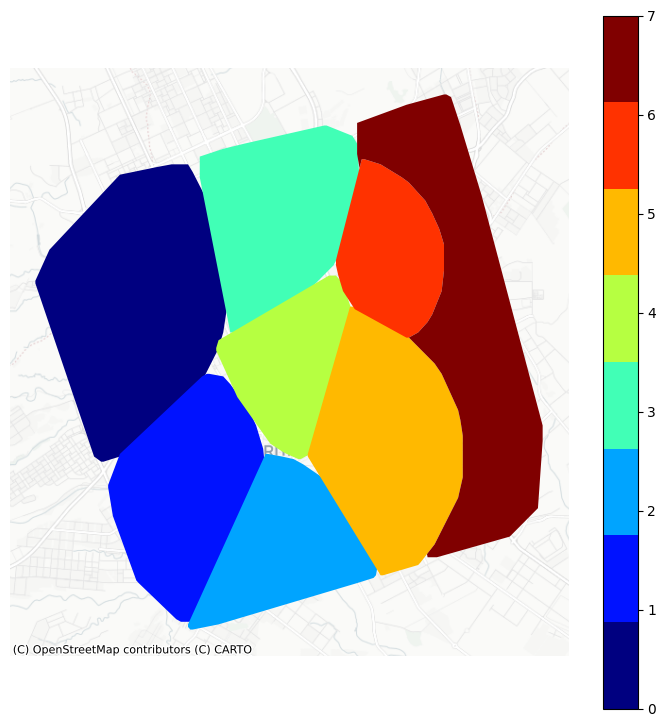

In [21]:
aggeraged_output = data.groupby("group", observed=False).agg({
    "number_of_persons": "sum",
    "effective_population": "sum",
    "number_of_supermarkets": "sum",
    "number_of_potential_customers": "sum"
})
display(aggeraged_output)

boundaries = []
for group in data.group.unique():
    geometry = data.loc[data.group==group].geometry.union_all().convex_hull
    boundaries.append({
        "group": group,
        "geometry": geometry
    })
boundaries = pd.DataFrame(boundaries)
boundaries = boundaries.merge(aggeraged_output, on="group")
boundaries = gpd.GeoDataFrame(boundaries)
boundaries.loc[7, "geometry"] = boundaries.loc[7, "geometry"].difference(boundaries.loc[6, "geometry"]).difference(boundaries.loc[5, "geometry"])
plot_results(boundaries[["geometry", "group"]], 1, 1, [plt.get_cmap('jet', 8)], alpha=1, show_legends=True, edge_color=None, show_title=False, log_output=False)

## Results and Insights

### Analysis of Riyadh City

The methodology was applied to **Riyadh City**, and the following results were obtained:

| Group | Number of Persons | Effective Population | Number of Supermarkets | Number of Potential Customers |
|--------|-------------------|----------------------|------------------------|--------------------------------|
| 0      | 135,603          | 1218.67              | 1087                   | 658,435.23                    |
| 1      | 152,031          | 1324.64              | 820                    | 658,795.36                    |
| 2      | 134,052          | 871.54               | 702                    | 658,312.96                    |
| 3      | 138,996          | 1028.17              | 808                    | 658,597.98                    |
| 4      | 203,813          | 1230.40              | 604                    | 658,398.34                    |
| 5      | 162,334          | 1119.70              | 909                    | 658,514.08                    |
| 6      | 132,442          | 811.17               | 604                    | 658,938.15                    |
| 7      | 129,724          | 1000.70              | 1000                   | 655,339.48                    |

### Key Observations

1. **Effective Population vs. Supermarket Distribution:**
   - The **effective population** per group varies based on the supermarket accessibility in each region. 
   - Groups with fewer supermarkets tend to have a higher effective population, suggesting potential demand pressure on the existing retail infrastructure.

2. **Number of Potential Customers:**
   - Across all groups, the **number of potential customers remains relatively stable (~658,000 per group)**, indicating a balanced allocation of market demand.
   - This validates the effectiveness of the clustering algorithm in ensuring equitable sales regions.

3. **Variations in Supermarket Density:**
   - Group 7 has **the highest number of supermarkets (1000)** but one of the lower effective populations, suggesting it covers a highly commercialized area with dense retail access.
   - Group 6 has **the fewest supermarkets (604)** and the lowest effective population per supermarket, implying sparse supermarket availability.

4. **Implications for Sales Strategy:**
   - Sales teams operating in **high supermarket density areas (e.g., Group 7)** may face greater competition but also greater market opportunities.
   - Conversely, teams in **low supermarket density areas (e.g., Group 6)** may need targeted strategies to engage with underserved consumers.

## Conclusion

This analysis provides a fair way to divide sales regions based on consumer demand and supermarket access. By using effective population as a metric, businesses can ensure their sales teams operate in regions with equitable market opportunities, leading to improved efficiency and profitability.


